In [1]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from keras.metrics import MeanRelativeError
from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape
from keras.losses import MeanSquaredError
from keras.optimizers import Adam

In [2]:
DATA_PATH = 'data_cars/'
all_files = os.listdir(DATA_PATH)

In [3]:
all_dataframes = []
number_of_files = 1
number_of_sensors = 1

for index, file in enumerate(all_files):
    if index == number_of_files:
        break
    print(f"Reading file: {file}")
    file_name = file.split('.')[0]
    df = pd.read_csv(DATA_PATH + file, sep=';')

    df['date'] = pd.to_datetime(df[file_name], format='%Y-%m-%d %H:%M')
    df = df.drop(columns=[file_name])

    df = df.set_index('date')
    df.columns = [f"{file_name}_{col}" for col in df.columns if col != 'date']
    if number_of_sensors:
        all_dataframes.append(df[df.columns[:number_of_sensors]])
    else:
        all_dataframes.append(df)
    print(f"Finished reading file: {file}, shape = {df.shape}")

combined_df = pd.concat(all_dataframes, axis=1)
combined_df.fillna(method='ffill', inplace=True)
combined_df['hour'] = combined_df.index.hour
combined_df['day_of_week'] = combined_df.index.dayofweek

data = np.array(combined_df, dtype=float)
scaler = StandardScaler()
#Don't transform the time labels -> this way the scaler also works inversely on prediction data because shapes are different otherwise
data = np.append(scaler.fit_transform(data[:, :-2]), data[:, -2:], axis=1)

Reading file: K711.csv
Finished reading file: K711.csv, shape = (2880, 31)


In [4]:
data

array([[-9.09677914e-01,  0.00000000e+00,  4.00000000e+00],
       [-1.08788234e+00,  0.00000000e+00,  4.00000000e+00],
       [-6.42371273e-01,  0.00000000e+00,  4.00000000e+00],
       ...,
       [-1.86557760e-02,  2.30000000e+01,  5.00000000e+00],
       [-8.20575700e-01,  2.30000000e+01,  5.00000000e+00],
       [-9.09677914e-01,  2.30000000e+01,  5.00000000e+00]])

In [5]:
def split_sequence(seq, look_back, look_forward):
    # Declare X and y as empty list
    X, y = [], []
    # scalers = [StandardScaler() for _ in range(seq.shape[1] - 2)]  # excluding last 2 columns

    # # Apply scalers
    # for i in range(seq.shape[1] - 2):  # excluding last 2 columns
    #     seq[:, i] = scalers[i].fit_transform(seq[:, i].reshape(-1, 1)).flatten()

    for i in range(len(seq)):
        # get the last index
        lastIndex = i + look_back

        # if lastIndex is greater than length of sequence then break
        if lastIndex + look_forward > len(seq):
            break

        # Create input and output sequence
        # Last 2 columns are time of day and day of week
        seq_X, seq_y = seq[i:lastIndex], seq[lastIndex+look_forward-1, :-2]

        # append seq_X, seq_y in X and y list
        X.append(seq_X)
        y.append(seq_y)

    # Convert X and y into numpy array
    X, y = np.array(X), np.array(y)

    return X, y

In [6]:
def split_data(data, train_size, val_size, shuffle, look_back, steps_in_future):
    num_of_steps = data.shape[0]
    # train_size = 0.6
    # val_size = 0.15
    # shuffle = True
    # look_back = 75
    # steps_in_future = 1

    x, y = split_sequence(data, look_back, steps_in_future)
    
    # data = np.append(scaler.fit_transform(data[:, :-2]), data[:, -2:], axis=1)

    if shuffle:
        idx = np.random.permutation(len(x))
        x,y = x[idx], y[idx]

    num_train = int(num_of_steps * train_size)
    num_val = int(num_of_steps * val_size)

    x_train, y_train = x[:num_train], y[:num_train]
    x_val, y_val = x[num_train:num_train + num_val], y[num_train:num_train + num_val]
    x_test, y_test = x[num_train + num_val:], y[num_train + num_val:]

    return x_train, y_train, x_val, y_val, x_test, y_test


In [7]:
def smape(predicted, actual):
    return (
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100

In [8]:
def run_model(x_train, y_train, x_val, y_val, x_test, y_test, epochs=100, batch_size=32):
    # Add params to do optimizing at the top
    input_dim = data.shape[1]
    units = 128
    output_size = y_train.shape[1]
    look_back = 75

    input = keras.Input((look_back, input_dim))
    #return sequences is necessary for sequential LSTM layers
    lstm1 = LSTM(units, return_sequences=True)(input)
    lstm2 = LSTM(units)(lstm1)
    out = Dense(output_size)(lstm2)
    model = keras.models.Model(inputs=input, outputs=out)
    model.summary()

    model.compile(
        loss=MeanSquaredError(),
        optimizer=Adam(learning_rate=0.001),
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        #makes the training stop early if it notices no improvements on the validation set 10 times in a row, to prevent overfitting
        callbacks=[keras.callbacks.EarlyStopping(patience=10)],
    )

    # make predictions
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)        

    print(trainPredict.shape, testPredict.shape)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(y_train)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(y_test)
    
    # calculate root mean squared error
    trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
    trainScoreRelative = mean_absolute_percentage_error(trainY, trainPredict)
    
    print(f'Train Score: {trainScore:.2f} RMSE')
    testScore = np.sqrt(mean_squared_error(testY, testPredict))
    testScoreRelative = mean_absolute_percentage_error(trainY, trainPredict)
    print(f'Test Score: {testScore:.2f} RMSE')
    
    train_smape = smape(trainPredict, trainY)
    test_smape = smape(testPredict, testY)
    print(f'Train SMAPE: {np.mean(train_smape):.2f}')
    print(f'Test SMAPE: {np.mean(test_smape):.2f}')

    return trainPredict, testPredict, trainScore, testScore, trainY, testY, train_smape, test_smape


In [9]:

# Check if 'results' directory exists
if not os.path.exists('results'):
    os.makedirs('results')


In [10]:
results_df = pd.DataFrame()

train_scores = []
test_scores = []
runs = 20
steps_in_future = [(i*4+1) for i in range(11)]
current_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')


for i in steps_in_future:
    print(f'Running for {i} steps in future')
    results_df[f'train_score_{i}'] = np.nan
    results_df[f'test_score_{i}'] = np.nan
    results_df[f'train_relative_error_{i}'] = np.nan
    results_df[f'test_relative_error_{i}'] = np.nan

    x_train, y_train, x_val, y_val, x_test, y_test = split_data(data, train_size=22/30, val_size=5/30, shuffle=False, look_back=75, steps_in_future=i)

    for j in range(runs):
        trainPredict, testPredict, train_scores, test_scores, trainY, testY, train_smape, test_smape = run_model(x_train, y_train, x_val, y_val, x_test, y_test, epochs=500)
        results_df.loc[j, f'train_score_{i}'] = train_scores
        results_df.loc[j, f'test_score_{i}'] = test_scores
        results_df.loc[j, f'train_relative_error_{i}'] = np.mean(train_smape)
        results_df.loc[j, f'test_relative_error_{i}'] = np.mean(test_smape)

        
        # results_df.loc[j, f'train_relative_error_{i}'] = train_relative_error
        # results_df.loc[j, f'test_relative_error_{i}'] = test_relative_error
    results_df.to_csv(f'results/results_{current_time}.csv', index=False)
    # train_scores.append(res[2])
    # test_scores.append(res[3])

# results_df[f"train"] = train_scores
# results_df[f"test"] = test_scores
    


Running for 1 steps in future
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 3)]           0         
                                                                 
 lstm (LSTM)                 (None, 75, 128)           67584     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 199,297
Trainable params: 199,297
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500


2023-06-04 02:16:02.741612: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


66/66 [==============================] - 3s 29ms/step - loss: 0.3688 - root_mean_squared_error: 0.6072 - val_loss: 0.2605 - val_root_mean_squared_error: 0.5104
Epoch 2/500
66/66 [==============================] - 1s 22ms/step - loss: 0.2558 - root_mean_squared_error: 0.5057 - val_loss: 0.2437 - val_root_mean_squared_error: 0.4937
Epoch 3/500
66/66 [==============================] - 1s 22ms/step - loss: 0.2411 - root_mean_squared_error: 0.4910 - val_loss: 0.1921 - val_root_mean_squared_error: 0.4382
Epoch 4/500
66/66 [==============================] - 2s 23ms/step - loss: 0.2308 - root_mean_squared_error: 0.4804 - val_loss: 0.2064 - val_root_mean_squared_error: 0.4543
Epoch 5/500
66/66 [==============================] - 2s 23ms/step - loss: 0.2117 - root_mean_squared_error: 0.4601 - val_loss: 0.1725 - val_root_mean_squared_error: 0.4154
Epoch 6/500
66/66 [==============================] - 1s 22ms/step - loss: 0.2162 - root_mean_squared_error: 0.4650 - val_loss: 0.1732 - val_root_mean_sq

In [11]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data(data, train_size=22/30, val_size=3/30, shuffle=False, look_back=75, steps_in_future=5)


In [12]:
trainPredict, testPredict, train_scores, test_scores, trainY, testY, train_smape, test_smape = run_model(x_train, y_train, x_val, y_val, x_test, y_test, epochs=500)


Model: "model_220"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_221 (InputLayer)      [(None, 75, 3)]           0         
                                                                 
 lstm_440 (LSTM)             (None, 75, 128)           67584     
                                                                 
 lstm_441 (LSTM)             (None, 128)               131584    
                                                                 
 dense_220 (Dense)           (None, 1)                 129       
                                                                 
Total params: 199,297
Trainable params: 199,297
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
66/66 [==============================] - 45s 504ms/step - loss: 0.3747 - root_mean_squared_error: 0.6122 - val_loss: 0.2008 - val_root_mean_squared_error: 0.4481
Epoch 2/5

In [13]:
trainPredict.shape

(2112, 1)

In [14]:
testY.shape

(401, 1)

In [15]:
smape_train = smape(trainPredict, trainY)

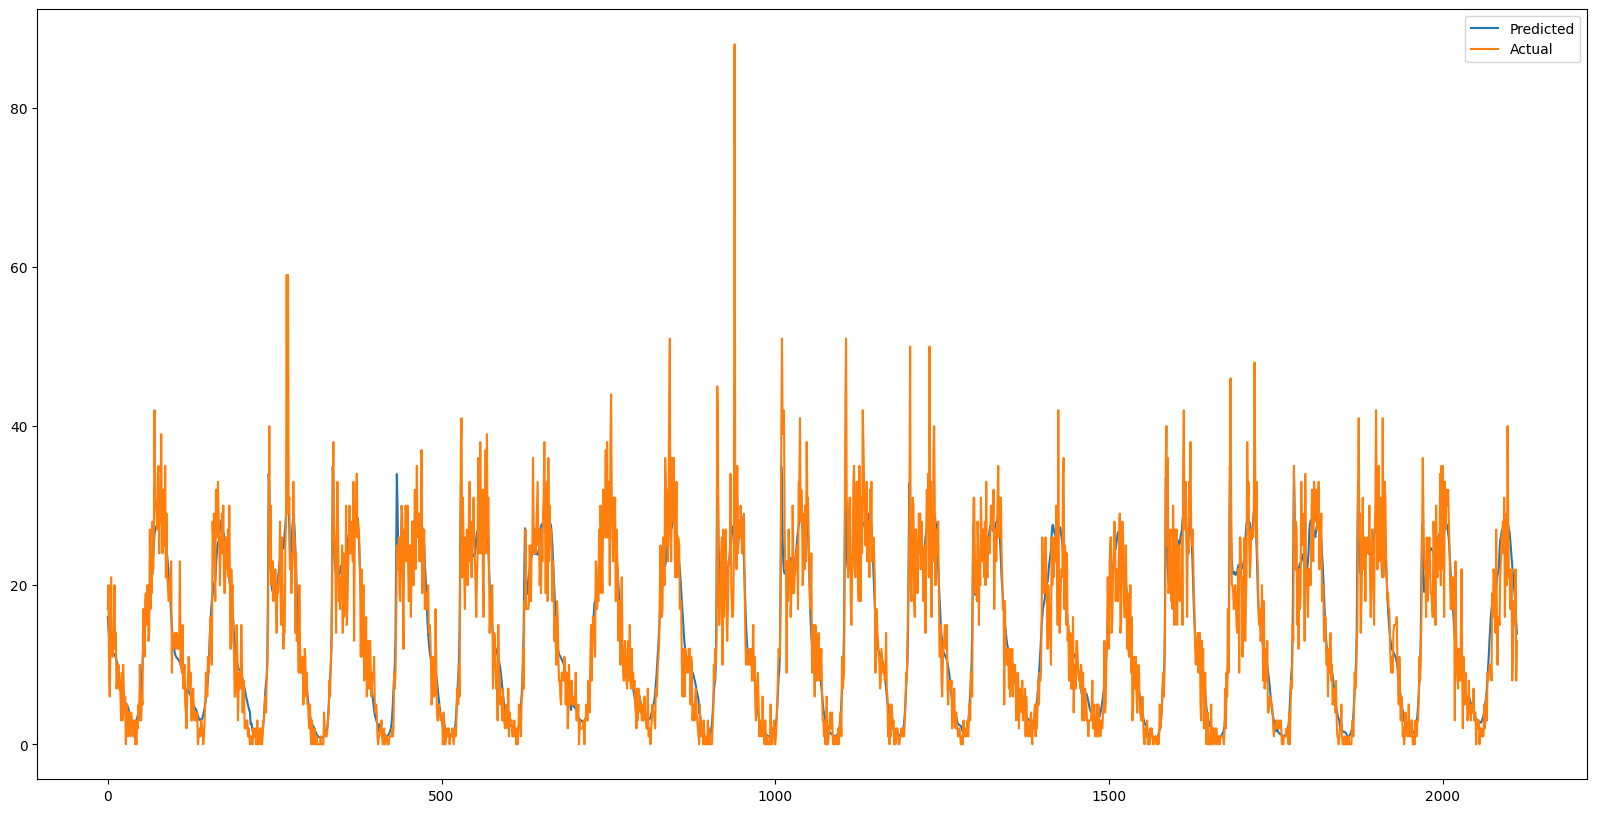

In [16]:
# Plot the training predictions
plt.figure(figsize=(20,10))
plt.plot(trainPredict, label='Predicted')
plt.plot(trainY, label='Actual')
plt.legend()
plt.show()

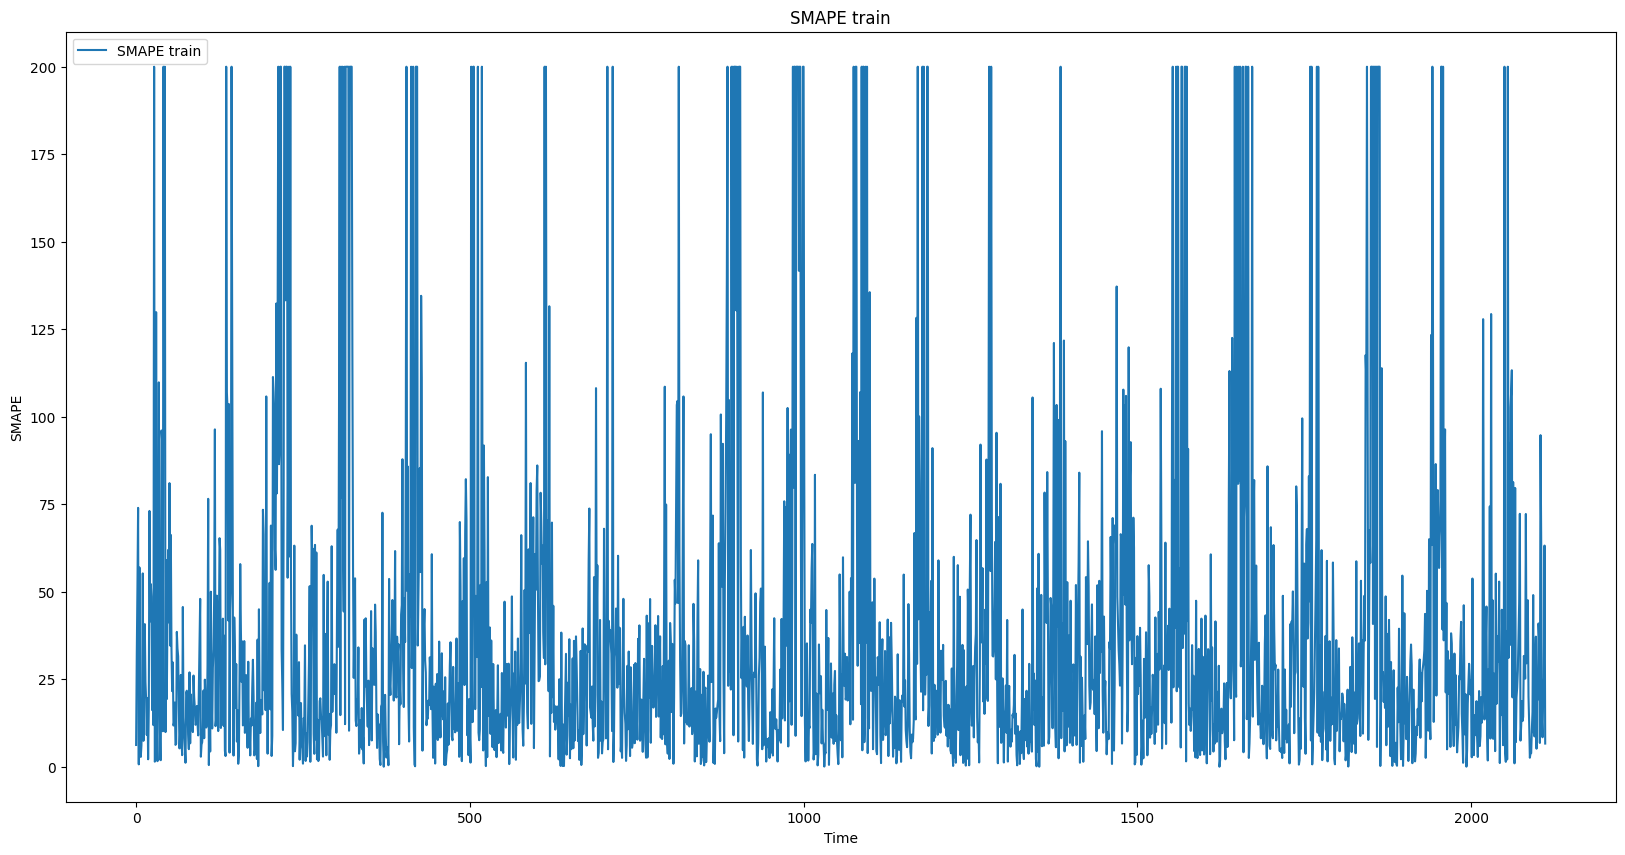

In [17]:
# Plot the numpy smape_train
plt.figure(figsize=(20,10))

plt.plot(smape_train)
plt.title('SMAPE train')
plt.ylabel('SMAPE')
plt.xlabel('Time')
plt.legend(['SMAPE train'], loc='upper left')
plt.show()

In [18]:
# Separate train and test mean scores
mean_train_scores = [mean_scores[f'train_score_{t+1}'] for t in range(steps_in_future)]
mean_test_scores = [mean_scores[f'test_score_{t+1}'] for t in range(steps_in_future)]

# Calculate time step * 15 minutes
time_steps = [t * 15 for t in range(1, steps_in_future +1)]

# Create a new figure
plt.figure()

# Plot mean train scores
plt.plot(time_steps, mean_train_scores, label='Train')

# Plot mean test scores
plt.plot(time_steps, mean_test_scores, label='Test')

# Add labels and legend
plt.title("Mean RMSE scores for each step in future")
plt.xlabel('Time (minutes)')
plt.ylabel('RMSE Score')
plt.legend()

# Show the plot
plt.show()


TypeError: 'list' object cannot be interpreted as an integer

In [ ]:
results_15_minutes_df = pd.DataFrame(results, columns=['train_score', 'test_score'])

In [ ]:
results_df.mean()

train_score    4.622932
test_score     4.963298
dtype: float64

In [ ]:
results

{'future_1_train': [4.632650258924434,
  4.702043000842466,
  4.752688680575258,
  5.211001972415112,
  4.726277750742752],
 'future_1_test': [5.208744726027466,
  5.0170035957195855,
  5.370894518538013,
  5.590523368209224,
  5.334273742172052],
 'future_2_train': [4.820590931170894,
  5.1156329232766,
  4.808833718573414,
  5.068796086299877,
  4.916576410235235],
 'future_2_test': [4.35104246616713,
  4.561267867029716,
  4.33644006756498,
  4.531890554067091,
  4.4078814758626645],
 'future_3_train': [4.63936313956421,
  4.5818767832813725,
  4.364107518548016,
  4.910827868400142,
  4.633969051831753],
 'future_3_test': [5.34659916636886,
  5.124014134136234,
  5.213419066275717,
  5.161538008455555,
  5.152773225770472],
 'future_4_train': [4.785077342559298,
  4.859751694874726,
  4.845917248944688,
  4.834347006492255,
  4.925220299285164],
 'future_4_test': [4.267655324996809,
  4.3507507146801725,
  4.288069165291359,
  4.368294959857023,
  4.375840953110822],
 'future_5_tra

In [ ]:
results_df = pd.DataFrame.from_dict(results)

In [ ]:
results_df.mean()

future_1_train    4.804932
future_1_test     5.304288
future_2_train    4.946086
future_2_test     4.437704
future_3_train    4.626029
future_3_test     5.199669
future_4_train    4.850063
future_4_test     4.330122
future_5_train    4.345653
future_5_test     4.648809
future_6_train    4.396515
future_6_test     5.576481
future_7_train    4.575507
future_7_test     5.272119
future_8_train    4.636510
future_8_test     4.852000
future_9_train    4.544041
future_9_test     5.459930
dtype: float64

In [ ]:
train_df = pd.DataFrame(trainPredict, columns=['train_predict'])
train_df['train_actual'] = trainY

In [ ]:
# Make a graph of this
train_df[:100].plot()

RangeIndex(start=0, stop=1728, step=1)